In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cols
import matplotlib.cm as cm

SingleDim = 9
UNOCCUPIED = 0

board = np.zeros(shape=(SingleDim,SingleDim), dtype=int)
board[0,2] = 1
board[2,1] = 1

vacant = board == UNOCCUPIED

vacant_i = np.array(list(zip(*np.nonzero(vacant))))
v2 = vacant_i.copy()
np.random.shuffle(v2)
v2 = v2[:14]
v2[:,0], v2[:,1]

(array([8, 0, 8, 8, 0, 5, 4, 2, 6, 5, 8, 2, 1, 6]),
 array([7, 8, 3, 1, 3, 2, 5, 6, 0, 6, 2, 0, 7, 5]))

In [2]:
board[v2[:,0], v2[:,1]] = [7,2,3,4,5,6,7,2,3,4,5,6,1,1]

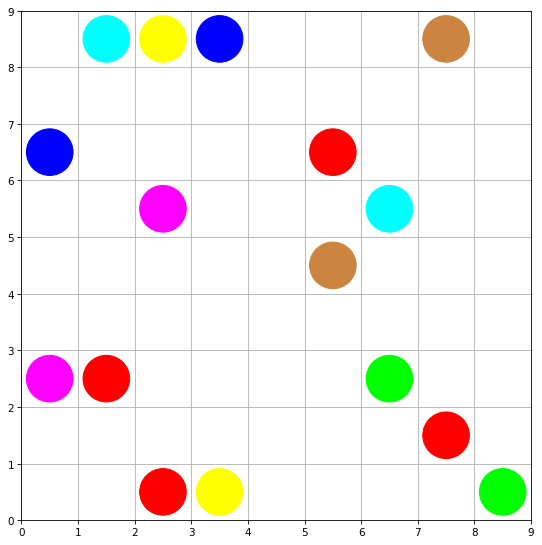

In [3]:
cmap = 'wrgybcm'
lines_cm = cols.ListedColormap([[1, 0, 0],
                               [0, 1, 0],
                               [0, 0, 1],
                               [0, 1, 1],
                               [1, 1, 0],
                               [1, 0, 1],
                               [.8,.52,.25]])

x,y = np.nonzero(board != UNOCCUPIED)
fig = plt.figure(figsize=(SingleDim,SingleDim), dpi=75)
ax = plt.subplot(111, aspect='equal', xlim=[0,SingleDim], ylim=[0,SingleDim], 
                 xticks=range(SingleDim+1), yticks=range(SingleDim+1))
ax.grid(True)
ax.scatter(y+0.5, x+0.5, s=2000, c=[board[x1,y1] for x1,y1 in zip(x,y)], 
           cmap=lines_cm)

In [4]:
from itertools import product
from dijkstar import Graph, find_path
graph = Graph()
for disp in [(1,0), (0,1), (-1,0), (0,-1)]:
    if disp[0] != 0 :
        row_plus = (1-disp[0])//2
    else:
        row_plus = 0
    if disp[1] != 0 :
        col_plus = (1-disp[1])//2
    else:
        col_plus = 0
    
    for r,c in product(range(row_plus, min(SingleDim,SingleDim-disp[0])), 
                       range(col_plus, min(SingleDim,SingleDim-disp[1]))):
        loc = (r,c)
        adj_loc = (loc[0]+disp[0],loc[1]+disp[1])
        graph.add_edge(loc, adj_loc, (loc,adj_loc))

path = find_path(graph, (0,0), (3,0), 
              cost_func=lambda u,v,e,pe: 0.001+int(board[v]!=UNOCCUPIED))

In [5]:
path

PathInfo(nodes=[(0, 0), (1, 0), (1, 1), (1, 2), (2, 2), (3, 2), (3, 1), (3, 0)], edges=[((0, 0), (1, 0)), ((1, 0), (1, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((2, 2), (3, 2)), ((3, 2), (3, 1)), ((3, 1), (3, 0))], costs=[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], total_cost=0.007)

In [ ]:
orig_dirs = [(-1,0),(-1,-1),(0,-1),(1,-1)]
isInRange = lambda loc: np.all(loc>=0 and loc<SingleDim)

def getStraitConnection(board, location, color):
    connection = []
    for shift in orig_dirs:
        line = []
        
        loc = location
        while True:
            loc += shift
            if not isInRange(loc) or board[loc] != color: break
            line.append(loc)
        loc = location
        while True:
            loc -= shift
            if not isInRange(loc) or board[loc] != color: break
            line.append(loc)
        
        if len(line) >= MIN_LINE_ELIMINATION_SIZE-1:
            connection.append(*line)
    
    if len(connection) > 0: connection.append(location)
    return connection
    
def getLinesTransition(board, src, dst):
    err = (board, ERROR_REWARD)
    c = board[src]
    if c == UNOCCUPIED or board[dst] == UNOCCUPIED: return err
    path = getPath(board, src, dst)
    if path.total_cost > 1.0: return err
    
    conn = getStraitConnection(board, dst, board[src])
    b = board.copy()
    b[conn[:,0],conn[:,1]] = UNOCCUPIED
    return (b, len(conn))